# 1. Extracción de datos

## 1.1 Datos scheduled y eventos

In [60]:
import os
import sys
import pandas as pd

# 1. Configuración de la ruta para importar src en un Jupyter Notebook
ruta_raiz = os.path.abspath(os.path.join(os.getcwd(), "..")) 

if ruta_raiz not in sys.path:
    sys.path.insert(0, ruta_raiz)

# Importamos la función para descargar Parquet
from src.common.minio_client import download_df_parquet

# 2. Obtenemos las credenciales
access_key = os.getenv("MINIO_ACCESS_KEY")
if access_key is None:
    raise AssertionError("MINIO_ACCESS_KEY no definida. Configúrala antes de ejecutar.")

secret_key = os.getenv("MINIO_SECRET_KEY")
if secret_key is None:
    raise AssertionError("MINIO_SECRET_KEY no definida. Configúrala antes de ejecutar.")


dia_descarga = "2025-01-07"
nombreGTFS = f"gtfs_scheduled_{dia_descarga}.parquet" 
nombreEvento = f"eventos_{dia_descarga}.parquet" 


ruta_parquet_scheduled = f"grupo5/cleaned/gtfs_clean_scheduled/date={dia_descarga}/{nombreGTFS}"
ruta_parquet_eventos = f"grupo5/cleaned/eventos_nyc/date={dia_descarga}/{nombreEvento}"


try:
    
    
  
    df_s = download_df_parquet(
        access_key=access_key, 
        secret_key=secret_key, 
        object_name=ruta_parquet_scheduled
    )

    df_e = download_df_parquet(
        access_key=access_key, 
        secret_key=secret_key, 
        object_name=ruta_parquet_eventos
    )
    
    print("¡Descarga exitosa!\n")
    

except Exception as e:
    print(f"Ocurrió un error al intentar descargar el archivo")

¡Descarga exitosa!



## 1.2 Datos unscheduled

In [61]:
import pandas as pd

base_uns = "grupo5/cleaned/gtfs_clean_unscheduled"
filename_patterns = [
    "gtfs_unscheduled_{date}.parquet",
    "gtfs_clean_unscheduled_{date}.parquet",
    "gtfs_cleaned_unscheduled_{date}.parquet",
    "unscheduled_{date}.parquet",
]

def descargar_uns(fecha):
    for patt in filename_patterns:
        nombre = patt.format(date=fecha)
        path   = f"{base_uns}/date={fecha}/{nombre}"
        try:
            tmp = download_df_parquet(
                access_key=access_key,
                secret_key=secret_key,
                object_name=path,
            )
            tmp["service_date"] = pd.to_datetime(fecha)
            print(f"¡Descarga exitosa! ({nombre})\n")
            return tmp
        except Exception:
            continue
    return None

df_u = descargar_uns(dia_descarga)

if df_u is None:
    raise ValueError(f"No se encontró ningún parquet unscheduled para {dia_descarga}.")

# Preparar td_real
if "td_real" not in df_u.columns:
    if "actual_seconds" in df_u.columns:
        df_u["td_real"] = pd.to_timedelta(df_u["actual_seconds"], unit="s", errors="coerce")
    else:
        raise ValueError("El dataset unscheduled no tiene 'td_real' ni 'actual_seconds'.")

df_u.dropna(subset=["td_real"], inplace=True)
df_u["td_real"] = pd.to_timedelta(df_u["td_real"])

if "trip_uid" not in df_u.columns:
    raise ValueError("El dataset unscheduled no tiene 'trip_uid'.")


¡Descarga exitosa! (gtfs_unscheduled_2025-01-07.parquet)



# 2. Transformaciones

## 2.1 Formato de horas en df_e

In [62]:
import pandas as pd


df_e["hora_inicio"] = pd.to_datetime(
    df_e["hora_inicio"], 
    format='%H:%M', 
    errors='coerce'
).dt.strftime('%H:%M:%S')

df_e["hora_salida_estimada"] = pd.to_datetime(
    df_e["hora_salida_estimada"], 
    format='%H:%M', 
    errors='coerce'
).dt.strftime('%H:%M:%S')




## 2.2 Limpieza de df_s y cálculo de td_real

In [63]:

columnas_basura = [
    'scheduled_time',   
    'actual_time',     
    'is_unscheduled',   
    'hour_sin',         
    'hour_cos',        
    'dow',                   
]


df_s['hora_real_hhmm'] = pd.to_datetime(df_s['actual_seconds'], unit='s').dt.strftime('%H:%M:%S')
df_s['hora_programada_hhmm'] = pd.to_datetime(df_s['scheduled_seconds'], unit='s').dt.strftime('%H:%M:%S')
df_s.drop(columns=columnas_basura, inplace=True, errors='ignore')



# 3. Análisis y Gráficas

## 3.1 Impacto neto en retrasos (entrada / salida)

In [65]:
import pandas as pd


resumen_eventos = []


df_s['td_real'] = pd.to_timedelta(df_s['hora_real_hhmm'], errors='coerce')
df_s = df_s.dropna(subset=['td_real']) 


for index, evento in df_e.iterrows():
    nombre = evento['nombre_evento']
    parada = evento['stop_id']
    
   
    hora_inicio_math = pd.to_timedelta(evento['hora_inicio'])
    inicio_entrada = hora_inicio_math - pd.Timedelta(hours=1)
    fin_entrada = hora_inicio_math
    
    trenes_entrada = df_s[(df_s['td_real'] >= inicio_entrada) & (df_s['td_real'] <= fin_entrada)]
    
    retraso_entrada_evento = trenes_entrada[trenes_entrada['stop_id'] == parada]['delay_minutes'].mean()
    retraso_entrada_resto = trenes_entrada[trenes_entrada['stop_id'] != parada]['delay_minutes'].mean()
    
   
    hora_salida_math = pd.to_timedelta(evento['hora_salida_estimada'])
    inicio_salida = hora_salida_math
    fin_salida = hora_salida_math + pd.Timedelta(hours=1)
    
    trenes_salida = df_s[(df_s['td_real'] >= inicio_salida) & (df_s['td_real'] <= fin_salida)]
    
    retraso_salida_evento = trenes_salida[trenes_salida['stop_id'] == parada]['delay_minutes'].mean()
    retraso_salida_resto = trenes_salida[trenes_salida['stop_id'] != parada]['delay_minutes'].mean()
    
    
    resumen_eventos.append({
        'Evento': nombre,
        'Parada': parada,
       
        'Retraso Ciudad Entrada (Mins)': round(retraso_entrada_resto, 2) if pd.notna(retraso_entrada_resto) else 0,
        'Retraso Parada Entrada (Mins)': round(retraso_entrada_evento, 2) if pd.notna(retraso_entrada_evento) else 0,
        'Impacto NETO Entrada (Mins)': round(retraso_entrada_evento - retraso_entrada_resto, 2) if pd.notna(retraso_entrada_evento) and pd.notna(retraso_entrada_resto) else 0,
        
        
        'Retraso Ciudad Salida (Mins)': round(retraso_salida_resto, 2) if pd.notna(retraso_salida_resto) else 0,
        'Retraso Parada Salida (Mins)': round(retraso_salida_evento, 2) if pd.notna(retraso_salida_evento) else 0,
        'Impacto NETO Salida (Mins)': round(retraso_salida_evento - retraso_salida_resto, 2) if pd.notna(retraso_salida_evento) and pd.notna(retraso_salida_resto) else 0
    })


df_impacto = pd.DataFrame(resumen_eventos)


df_impacto = df_impacto.sort_values(by='Impacto NETO Salida (Mins)', ascending=False)


In [66]:
df_impacto.reset_index(drop=True, inplace= True)
df_impacto

,Evento,Parada,Retraso Ciudad Entrada (Mins),Retraso Parada Entrada (Mins),Impacto NETO Entrada (Mins),Retraso Ciudad Salida (Mins),Retraso Parada Salida (Mins),Impacto NETO Salida (Mins)
0,Dallas Stars at New York Rangers,128S,1.19,2.97,1.79,2.59,11.46,8.88
1,Street Health Outreach Wellness Program,J31S,0.76,2.67,1.91,1.38,4.58,3.20
2,Dallas Stars at New York Rangers,D17S,1.19,2.25,1.07,2.61,3.10,0.49
3,Dallas Stars at New York Rangers,129S,1.18,5.85,4.67,2.61,2.35,-0.26
4,Dallas Stars at New York Rangers,129N,1.19,0.14,-1.05,2.62,1.82,-0.79
5,Dallas Stars at New York Rangers,A28N,1.19,1.05,-0.14,2.62,1.53,-1.08
6,Dallas Stars at New York Rangers,633S,1.19,1.18,-0.01,2.62,1.44,-1.18
7,Street Health Outreach Wellness Program,M10S,0.77,-0.26,-1.03,1.38,0.14,-1.24
8,Dallas Stars at New York Rangers,R18S,1.19,0.73,-0.46,2.62,0.95,-1.67
9,Street Health Outreach Wellness Program,M10N,0.77,-0.23,-0.99,1.39,-0.32,-1.71


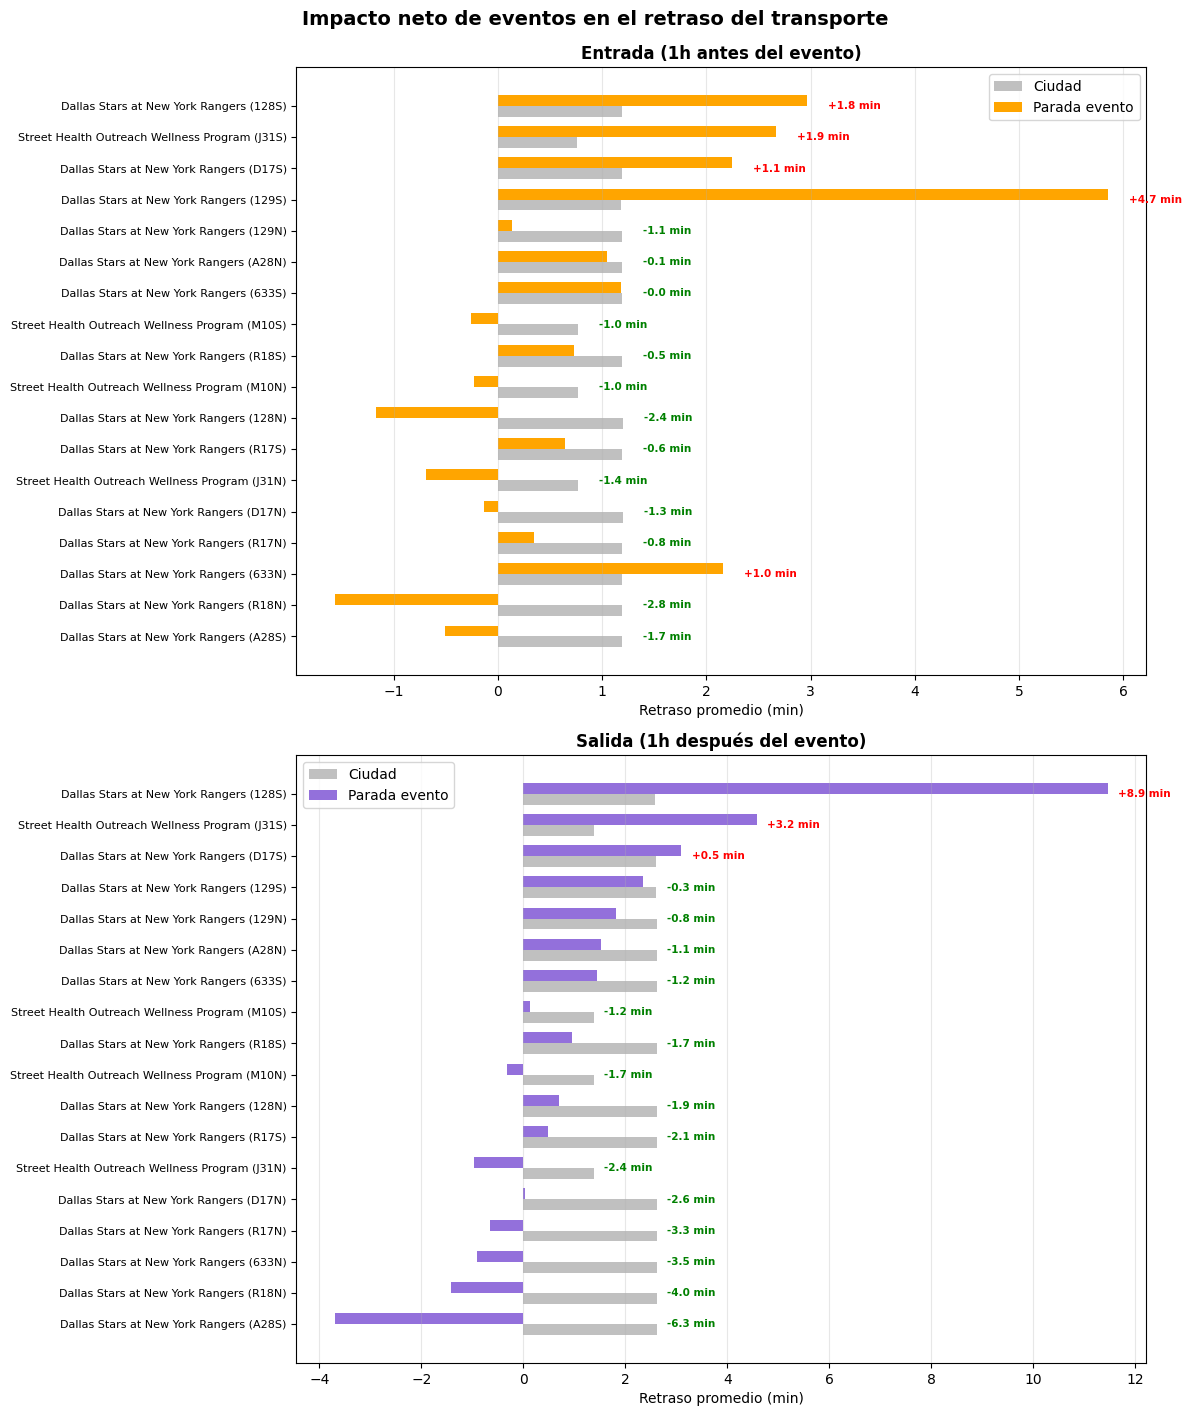

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

etiquetas = df_impacto['Evento'] + ' (' + df_impacto['Parada'].astype(str) + ')'
y = np.arange(len(etiquetas))
alto = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, max(10, len(etiquetas) * 0.8)))


ax1.barh(y + alto/2, df_impacto['Retraso Ciudad Entrada (Mins)'], alto, label='Ciudad', color='silver')
ax1.barh(y - alto/2, df_impacto['Retraso Parada Entrada (Mins)'], alto, label='Parada evento', color='orange')
for i, val in enumerate(df_impacto['Impacto NETO Entrada (Mins)']):
    xpos = max(df_impacto['Retraso Parada Entrada (Mins)'].iloc[i],
               df_impacto['Retraso Ciudad Entrada (Mins)'].iloc[i]) + 0.2
    color = 'red' if val > 0 else 'green'
    ax1.text(xpos, i, f'{val:+.1f} min', va='center', fontsize=7.5, fontweight='bold', color=color) #colocar el +-
ax1.set_title('Entrada (1h antes del evento)', fontweight='bold')
ax1.set_yticks(y)
ax1.set_yticklabels(etiquetas, fontsize=8)
ax1.set_xlabel('Retraso promedio (min)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()


ax2.barh(y + alto/2, df_impacto['Retraso Ciudad Salida (Mins)'], alto, label='Ciudad', color='silver')
ax2.barh(y - alto/2, df_impacto['Retraso Parada Salida (Mins)'], alto, label='Parada evento', color='mediumpurple')
for i, val in enumerate(df_impacto['Impacto NETO Salida (Mins)']):
    xpos = max(df_impacto['Retraso Parada Salida (Mins)'].iloc[i],
               df_impacto['Retraso Ciudad Salida (Mins)'].iloc[i]) + 0.2
    color = 'red' if val > 0 else 'green'
    ax2.text(xpos, i, f'{val:+.1f} min', va='center', fontsize=7.5, fontweight='bold', color=color)
ax2.set_title('Salida (1h después del evento)', fontweight='bold')
ax2.set_yticks(y)
ax2.set_yticklabels(etiquetas, fontsize=8)
ax2.set_xlabel('Retraso promedio (min)')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

fig.suptitle('Impacto neto de eventos en el retraso del transporte', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.show()

## 3.2 Análisis por fases (5 fases)

In [68]:
resumen_final = []

ventana = pd.Timedelta(hours=2)
fin_dia = pd.Timedelta(hours=23, minutes=59)

for index, fila in df_e.iterrows():
    evento_nombre = fila['nombre_evento']
    stop          = fila['stop_id']
    hora_inicio   = pd.to_timedelta(fila['hora_inicio'])
    hora_salida   = pd.to_timedelta(fila['hora_salida_estimada'])

    df_parada = df_s[df_s['stop_id'] == stop]

    antes   = df_parada[(df_parada['td_real'] >= hora_inicio - ventana*4) & (df_parada['td_real'] < hora_inicio - ventana)]
    entrada = df_parada[(df_parada['td_real'] >= hora_inicio - ventana)   & (df_parada['td_real'] < hora_inicio)]
    durante = df_parada[(df_parada['td_real'] >= hora_inicio)             & (df_parada['td_real'] <= hora_salida)]
    salida  = df_parada[(df_parada['td_real'] >  hora_salida)             & (df_parada['td_real'] <= hora_salida + ventana)]

    # Option 2: si el ventana post-salida excede el último tren disponible, se acota al último tren de la parada
    ultimo_tren    = df_parada['td_real'].dropna().max()
    inicio_despues = hora_salida + ventana
    if pd.isna(ultimo_tren) or inicio_despues > fin_dia:
        despues = df_parada[(df_parada['td_real'] > hora_salida) & (df_parada['td_real'] <= fin_dia)]
    else:
        despues = df_parada[(df_parada['td_real'] > inicio_despues)]

    resumen_final.append({
        'Evento':   evento_nombre,
        'Parada':   stop,
        'Antes':    round(antes['delay_minutes'].mean(),   2),
        'Entrada':  round(entrada['delay_minutes'].mean(), 2),
        'Durante':  round(durante['delay_minutes'].mean(), 2),
        'Salida':   round(salida['delay_minutes'].mean(),  2),
        'Después':  round(despues['delay_minutes'].mean(), 2),
    })

df_resumen = pd.DataFrame(resumen_final)


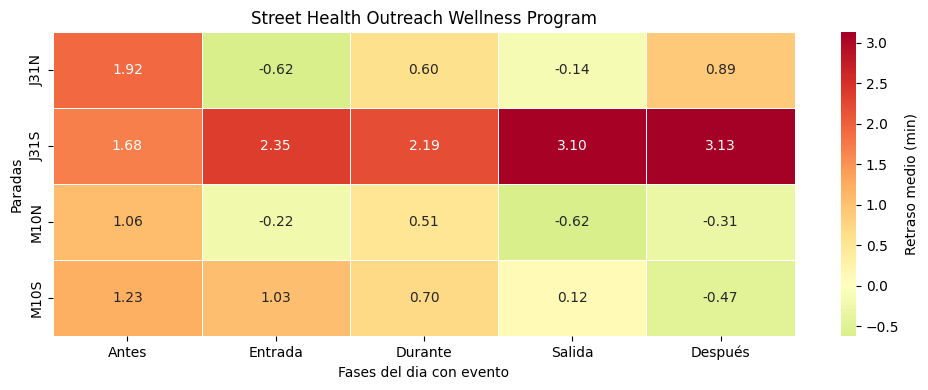

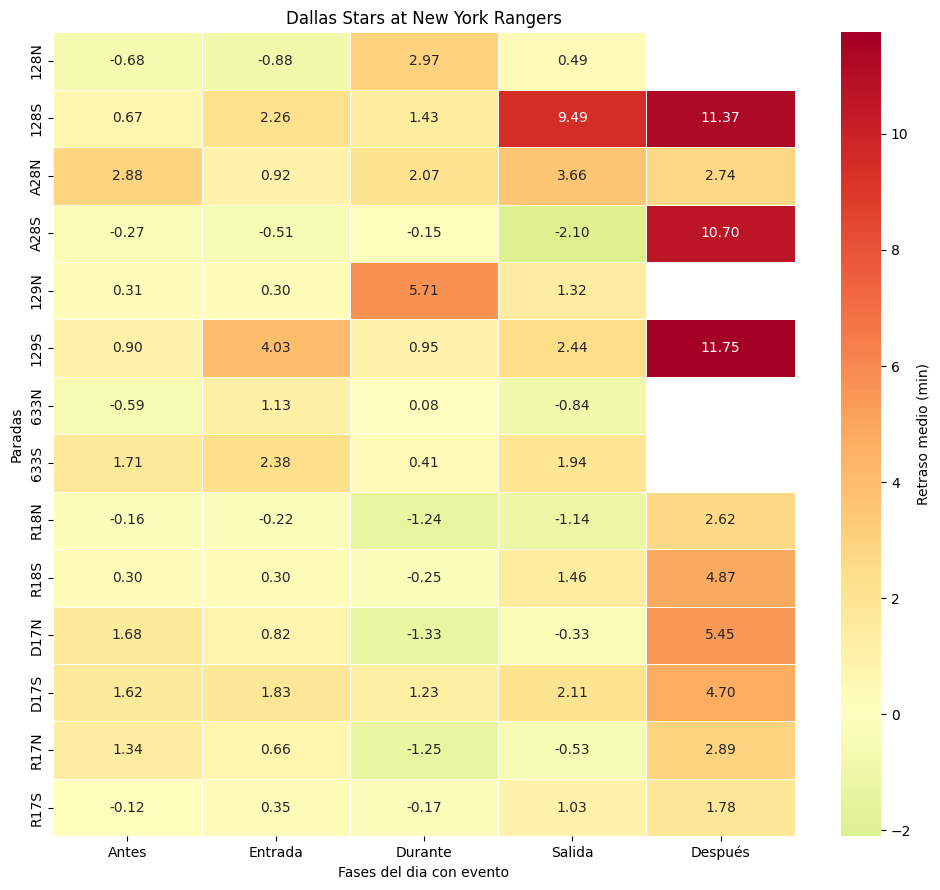

In [69]:



fases = ['Antes', 'Entrada', 'Durante', 'Salida', 'Después']

for evento_nombre in df_resumen['Evento'].unique():
    df_plot = df_resumen[df_resumen['Evento'] == evento_nombre].set_index('Parada')[fases]
    
    plt.figure(figsize=(10, len(df_plot) * 0.5 + 2))
    sns.heatmap(
        df_plot,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn_r',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Retraso medio (min)'}
    )
    plt.title(f'{evento_nombre}')
    plt.xlabel('Fases del dia con evento')
    plt.ylabel('Paradas')
    plt.tight_layout()
    plt.show()

## 3.3 Análisis simplificado (3 fases)

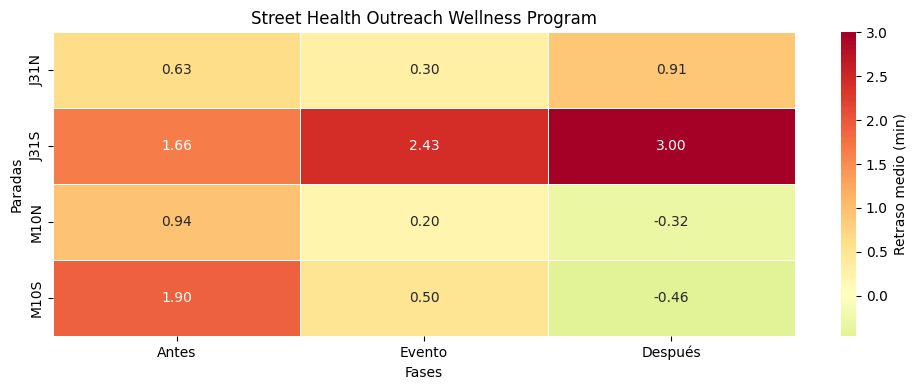

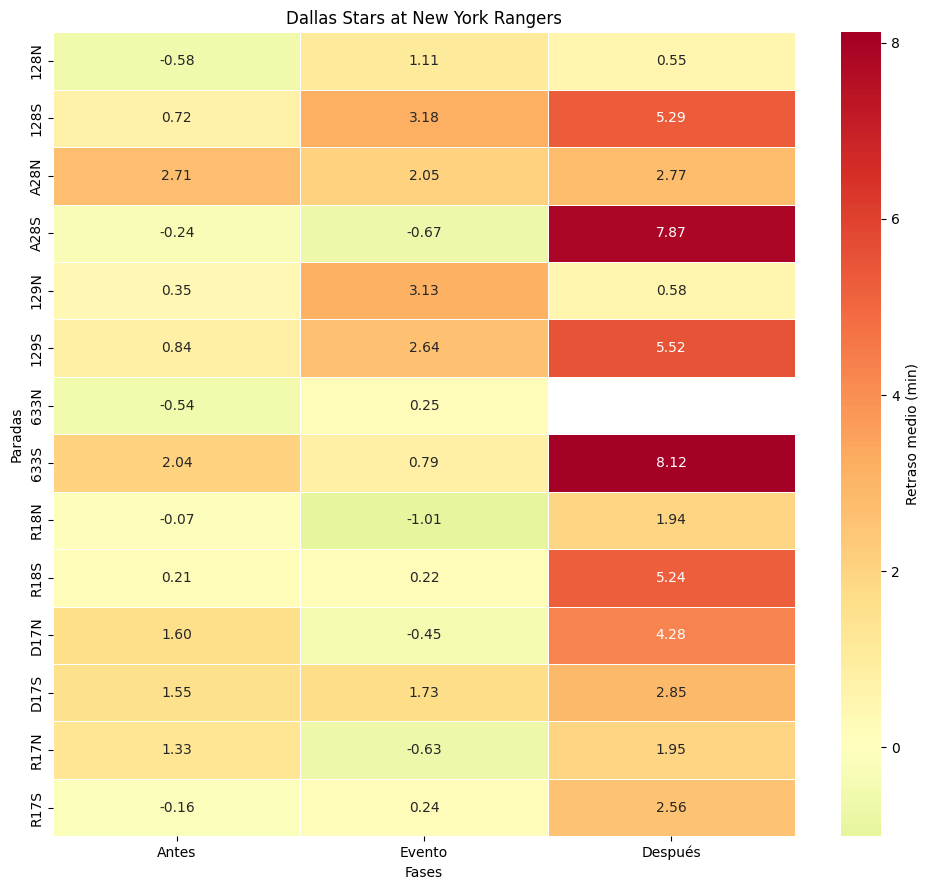

In [70]:


resumen_final_3 = []

ventana_antes = pd.Timedelta(hours=2)
ventana_evento = pd.Timedelta(hours=1.5)

for _, fila in df_e.iterrows():

    evento_nombre = fila["nombre_evento"]
    stop = fila["stop_id"]

    hora_inicio = pd.to_timedelta(fila["hora_inicio"])
    hora_salida = pd.to_timedelta(fila["hora_salida_estimada"])

    df_parada = df_s[df_s["stop_id"] == stop]

    antes = df_parada[
        (df_parada["td_real"] >= hora_inicio - ventana_antes*4) &
        (df_parada["td_real"] <  hora_inicio - ventana_evento)
    ]

    evento_ext = df_parada[
        (df_parada["td_real"] >= hora_inicio - ventana_evento) &
        (df_parada["td_real"] <= hora_salida + ventana_evento)
    ]

    despues = df_parada[
        (df_parada["td_real"] > hora_salida + ventana_evento)
    ]

    resumen_final_3.append({
        "Evento_nombre": evento_nombre,   
        "Parada": stop,
        "Antes": round(antes["delay_minutes"].mean(), 2),
        "Evento": round(evento_ext["delay_minutes"].mean(), 2),
        "Después": round(despues["delay_minutes"].mean(), 2),
    })

df_resumen_3fases_nuevo = pd.DataFrame(resumen_final_3)

fases_plot = ["Antes", "Evento", "Después"]

for evento_nombre in df_resumen_3fases_nuevo["Evento_nombre"].unique():

    df_plot = (
        df_resumen_3fases_nuevo[
            df_resumen_3fases_nuevo["Evento_nombre"] == evento_nombre
        ]
        .set_index("Parada")[fases_plot]
    )

    plt.figure(figsize=(10, len(df_plot)*0.5 + 2))

    sns.heatmap(
        df_plot,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn_r",
        center=0,
        linewidths=0.5,
        cbar_kws={"label": "Retraso medio (min)"}
    )

    plt.title(evento_nombre)

    plt.xlabel("Fases")
    plt.ylabel("Paradas")

    plt.tight_layout()
    plt.show()

## 3.4 Trenes unscheduled — antes / durante / después

,fecha_inicio,Evento,Antes,Durante,Después
0,2025-01-07,Dallas Stars at New York Rangers,91,237,39
1,2025-01-07,Street Health Outreach Wellness Program,0,13,0


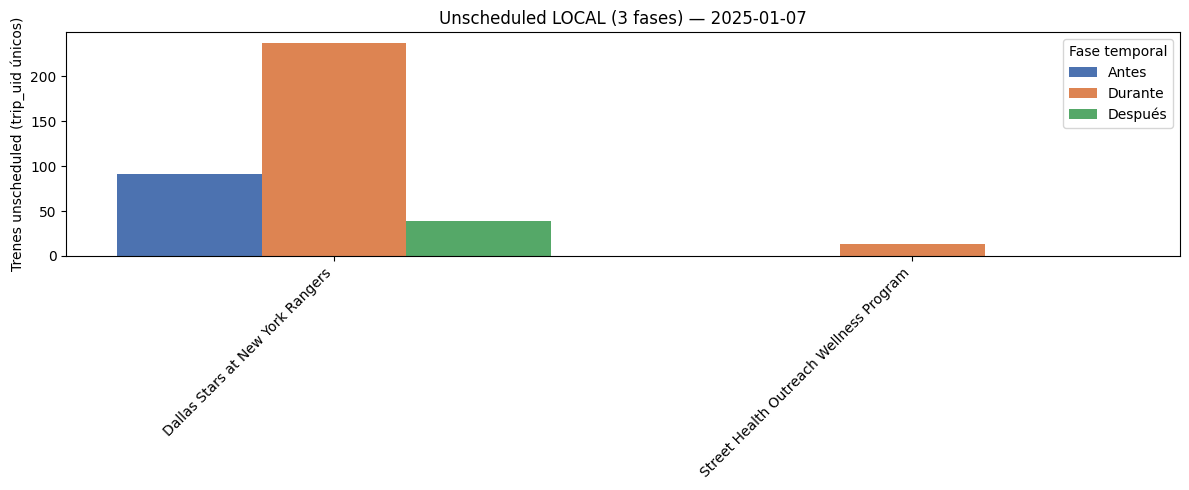

In [75]:
import matplotlib.pyplot as plt

ventana_uns = pd.Timedelta(hours=1.5)

eventos_uns = (
    df_e.groupby(["fecha_inicio", "nombre_evento"], as_index=False)
    .agg(
        hora_inicio=("hora_inicio", "first"),
        hora_salida_estimada=("hora_salida_estimada", "first"),
    )
)

def calcular_3_barras_local():
    rows = []
    for _, ev in eventos_uns.iterrows():
        fecha   = ev["fecha_inicio"]
        evento  = ev["nombre_evento"]
        inicio  = pd.to_timedelta(ev["hora_inicio"])
        salida  = pd.to_timedelta(ev["hora_salida_estimada"])
        
        stops_evento = (
            df_e[(df_e["fecha_inicio"] == fecha) & (df_e["nombre_evento"] == evento)]
            ["stop_id"].dropna().unique().tolist()
        )
        
        df_dia = df_u[(df_u["service_date"] == fecha) & (df_u["stop_id"].isin(stops_evento))]
        
        antes   = df_dia[(df_dia["td_real"] >= inicio - 2*ventana_uns) & (df_dia["td_real"] < inicio - ventana_uns)]
        durante = df_dia[(df_dia["td_real"] >= inicio - ventana_uns)   & (df_dia["td_real"] <= salida + ventana_uns)]
        despues = df_dia[(df_dia["td_real"] >  salida + ventana_uns)   & (df_dia["td_real"] <= salida + 2*ventana_uns)]
        
        rows.append({
            "fecha_inicio": fecha, "Evento": evento,
            "Antes":   antes["trip_uid"].nunique(),
            "Durante": durante["trip_uid"].nunique(),
            "Después": despues["trip_uid"].nunique(),
        })
    return pd.DataFrame(rows)

def plot_3_barras(df, titulo, orden_eventos):
    colores = {"Antes": "#4C72B0", "Durante": "#DD8452", "Después": "#55A868"}
    for fecha, sub in df.groupby("fecha_inicio"):
        orden = orden_eventos.get(fecha, sub["Evento"].tolist())
        sub   = sub.set_index("Evento").reindex(orden).reset_index()
        x     = range(len(sub))
        width = 0.25
        plt.figure(figsize=(12, 5))
        plt.bar([i-width for i in x], sub["Antes"],   width, color=colores["Antes"],   label="Antes")
        plt.bar(x,                    sub["Durante"],  width, color=colores["Durante"], label="Durante")
        plt.bar([i+width for i in x], sub["Después"], width, color=colores["Después"], label="Después")
        plt.xticks(list(x), sub["Evento"], rotation=45, ha="right")
        plt.ylabel("Trenes unscheduled (trip_uid únicos)")
        plt.title(f"{titulo} — {fecha}")
        plt.legend(title="Fase temporal")
        plt.tight_layout()
        plt.show()

df_local_3 = calcular_3_barras_local()
display(df_local_3)

orden_eventos = (
    df_local_3.sort_values(["fecha_inicio", "Durante"], ascending=[True, False])
    .groupby("fecha_inicio")["Evento"].apply(list).to_dict()
)

plot_3_barras(df_local_3, "Unscheduled LOCAL (3 fases)", orden_eventos)

## 3.5 Trenes unscheduled — 5 fases

,fecha_inicio,Evento,Antes,Entrada,Durante,Salida,Después
0,2025-01-07,Dallas Stars at New York Rangers,111,91,237,39,0
1,2025-01-07,Street Health Outreach Wellness Program,11,0,13,0,0


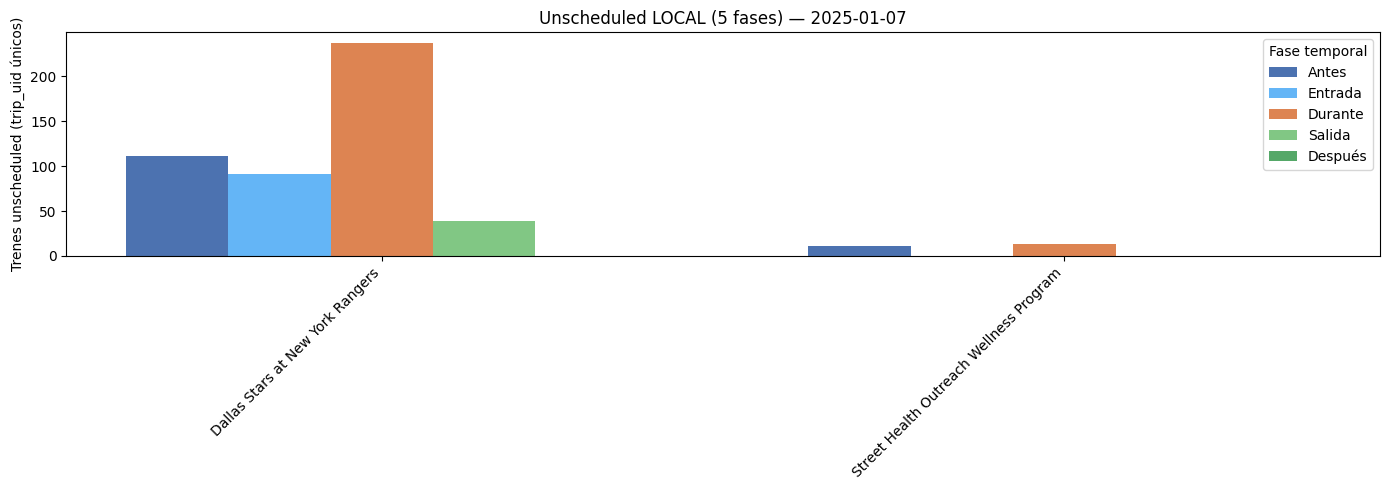

In [76]:
def calcular_5_barras_local():
    rows = []
    for _, ev in eventos_uns.iterrows():
        fecha   = ev["fecha_inicio"]
        evento  = ev["nombre_evento"]
        inicio  = pd.to_timedelta(ev["hora_inicio"])
        salida  = pd.to_timedelta(ev["hora_salida_estimada"])
        
        stops_evento = (
            df_e[(df_e["fecha_inicio"] == fecha) & (df_e["nombre_evento"] == evento)]
            ["stop_id"].dropna().unique().tolist()
        )
        
        df_dia = df_u[(df_u["service_date"] == fecha) & (df_u["stop_id"].isin(stops_evento))]
        
        antes   = df_dia[(df_dia["td_real"] >= inicio - 4*ventana_uns) & (df_dia["td_real"] < inicio - 2*ventana_uns)]
        entrada = df_dia[(df_dia["td_real"] >= inicio - 2*ventana_uns) & (df_dia["td_real"] < inicio - ventana_uns)]
        durante = df_dia[(df_dia["td_real"] >= inicio - ventana_uns)   & (df_dia["td_real"] <= salida + ventana_uns)]
        salida_w= df_dia[(df_dia["td_real"] >  salida + ventana_uns)   & (df_dia["td_real"] <= salida + 2*ventana_uns)]
        despues = df_dia[(df_dia["td_real"] >  salida + 2*ventana_uns) & (df_dia["td_real"] <= salida + 4*ventana_uns)]
        
        rows.append({
            "fecha_inicio": fecha, "Evento": evento,
            "Antes":   antes["trip_uid"].nunique(),
            "Entrada": entrada["trip_uid"].nunique(),
            "Durante": durante["trip_uid"].nunique(),
            "Salida":  salida_w["trip_uid"].nunique(),
            "Después": despues["trip_uid"].nunique(),
        })
    return pd.DataFrame(rows)

def plot_5_barras(df, titulo, orden_eventos):
    colores = {
        "Antes":   "#4C72B0",
        "Entrada": "#64B5F6",
        "Durante": "#DD8452",
        "Salida":  "#81C784",
        "Después": "#55A868",
    }
    for fecha, sub in df.groupby("fecha_inicio"):
        orden = orden_eventos.get(fecha, sub["Evento"].tolist())
        sub   = sub.set_index("Evento").reindex(orden).reset_index()
        x     = range(len(sub))
        width = 0.15
        plt.figure(figsize=(14, 5))
        offsets = [-2, -1, 0, 1, 2]
        for fase, offset in zip(["Antes", "Entrada", "Durante", "Salida", "Después"], offsets):
            plt.bar([i + offset*width for i in x], sub[fase], width, color=colores[fase], label=fase)
        plt.xticks(list(x), sub["Evento"], rotation=45, ha="right")
        plt.ylabel("Trenes unscheduled (trip_uid únicos)")
        plt.title(f"{titulo} — {fecha}")
        plt.legend(title="Fase temporal")
        plt.tight_layout()
        plt.show()

df_local_5 = calcular_5_barras_local()
display(df_local_5)

orden_eventos = (
    df_local_5.sort_values(["fecha_inicio", "Durante"], ascending=[True, False])
    .groupby("fecha_inicio")["Evento"].apply(list).to_dict()
)

plot_5_barras(df_local_5, "Unscheduled LOCAL (5 fases)", orden_eventos)